In [1]:
### This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import tensorflow_datasets as tfds
import tensorflow as tf

import nltk 
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 
from nltk.stem import SnowballStemmer

from sklearn import model_selection, metrics, preprocessing, ensemble, model_selection, metrics
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import random
from sklearn.model_selection import KFold
import re
import nltk
nltk.download('stopwords')
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
!pip install -q keras-tcn --no-dependencies
from tcn import TCN, tcn_full_summary

stop_words = list(stopwords.words('english'))
stemmer = SnowballStemmer(language = "english")

In [4]:
# Rreading train dataset
file_path = "/kaggle/input/nlp-getting-started/train.csv"
raw_data = pd.read_csv(file_path)
print("Data points count: ", raw_data['id'].count())
raw_data.head()

Data points count:  7613


,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Rreading train dataset
file_path = "/kaggle/input/nlp-getting-started/test.csv"
test_df = pd.read_csv(file_path)
print("Data points count: ", test_df['id'].count())
test_df.head()

Data points count:  3263


,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [8]:
def clean_text(each_text):
    # remove URL from text
    no_url = re.sub(r"http\S+", "", each_text)
    
    # remove numbers from text
    no_num = re.sub(r'\d+', '', no_url)

    # tokenize each text
    tokens = word_tokenize(no_num)
    
    # remove sptial character
    clean_text = []
    
    for word in tokens:
        clean_text.append("".join([ele for ele in word if ele.isalnum()]))

    # remove stop words and lower
    no_stop_word = [ele.lower() for ele in clean_text if not ele in stop_words]  

    # do stemming
    stemmed_text = [stemmer.stem(w) for w in no_stop_word]
    
    return " ".join(" ".join(stemmed_text).split())


raw_data['clean_text'] = raw_data['text'].apply(lambda x: clean_text(x) )
raw_data['clean_keyword'] = raw_data['clean_text'].apply(lambda x: clean_text(x) )


# Combine column 'clean_keyword' and 'clean_text' into one
raw_data['keyword_text'] = raw_data['clean_keyword'] + " " + raw_data["clean_text"]

In [10]:
feature = "keyword_text"
label = "target"

# split train and test
X_train, X_test,y_train, y_test = model_selection.train_test_split(raw_data[feature],raw_data[label],test_size=0.3,random_state=0,shuffle=True)

corpus=raw_data.loc[:,[feature,label]]
corpus.head()

,keyword_text,target
0,deed reason earthquak may allah forgiv us our ...,1
1,forest fire near la rong sask canada forest fi...,1
2,resid ask shelter place notifi offic evacu she...,1
3,peopl receiv wildfir evacu order california pe...,1
4,got sent photo rubi alaska smoke wildfir pour ...,1


In [167]:
raw_data.target = raw_data.target.astype(int)
sentences, labels = list(raw_data.text), list(raw_data.target)

In [169]:
def max_length(sequences):

    max_length = 0
    for i, seq in enumerate(sequences):
        length = len(seq)
        if max_length < length:
            max_length = length
    return max_length

In [170]:
from tcn import TCN, tcn_full_summary
from tensorflow.keras.layers import Input, Embedding, Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import concatenate, GlobalAveragePooling1D, GlobalMaxPooling1D
from tensorflow.keras.models import Model
from keras import backend as K

# example of l2 on a dense layer
from keras.layers import Dense
from keras.regularizers import l2


def define_model(kernel_size = 3, activation='relu', input_dim = None, output_dim=300, max_length = None ):
    
    inp = Input( shape=(max_length,))
    x = Embedding(input_dim=input_dim, output_dim=output_dim, input_length=max_length)(inp)
    x = SpatialDropout1D(0.4)(x)
    
    x = TCN(128,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn1')(x)
    x = TCN(64,dilations = [1, 2, 4], return_sequences=True, activation = activation, name = 'tcn2')(x)
    
    avg_pool = GlobalAveragePooling1D()(x)
    max_pool = GlobalMaxPooling1D()(x)
    
    conc = concatenate([avg_pool, max_pool])
    reg  = Dense(32, kernel_regularizer=l2(0.1), bias_regularizer=l2(0.1))(conc)
    drop = Dropout(0.4)(reg)
    x = Dense(16, activation="relu")(drop)
    drop = Dropout(0.4)(x)
    outp = Dense(1, activation="sigmoid")(drop)    

    model = Model(inputs=inp, outputs=outp)
    model.compile( loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    return model

In [171]:
model_0 = define_model( input_dim=1000, max_length=100)
K.set_value(model_0.optimizer.learning_rate, 0.0000001)
model_0.summary()

Model: "model_56"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_60 (InputLayer)          [(None, 100)]        0           []                               
                                                                                                  
 embedding_59 (Embedding)       (None, 100, 300)     300000      ['input_60[0][0]']               
                                                                                                  
 spatial_dropout1d_59 (SpatialD  (None, 100, 300)    0           ['embedding_59[0][0]']           
 ropout1D)                                                                                        
                                                                                                  
 tcn1 (TCN)                     (None, 100, 128)     400256      ['spatial_dropout1d_59[0][

In [172]:
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=0, 
                                             patience=10, verbose=2, 
                                             mode='auto', restore_best_weights=True)

In [173]:
# Parameter Initialization
trunc_type='post'
padding_type='post'
oov_tok = "<UNK>"

def clean(train_x=None,test_x=None ,pred = None):
    

    
    if pred == None :
                # encode data using
                # Cleaning and Tokenization
        tokenizer = Tokenizer(oov_token=oov_tok)
        tokenizer.fit_on_texts(train_x)

                # Turn the text into sequence
        training_sequences = tokenizer.texts_to_sequences(train_x)
        test_sequences = tokenizer.texts_to_sequences(test_x)

        max_len = max_length(training_sequences)

                # Pad the sequence to have the same size
        train_x = pad_sequences(training_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)
        test_x = pad_sequences(test_sequences, maxlen=max_len, padding=padding_type, truncating=trunc_type)    

        word_index = tokenizer.word_index
        length_vocab = len(word_index)+1    
    
        return train_x,test_x,length_vocab ,max_len
    
    if pred != None : 
        tokenizer = Tokenizer(oov_token=oov_tok)
        tokenizer.fit_on_texts(pred)

        # Turn the text into sequence
        test_sequences = tokenizer.texts_to_sequences(pred)

        #max_len = max_length(test_sequences)

        # Pad the sequence to have the same size
        test_x = pad_sequences(test_sequences, maxlen=33, padding=padding_type, truncating=trunc_type)
        

        word_index = tokenizer.word_index
        length_vocab = len(word_index)+1 
        
        return test_x,length_vocab 

In [175]:
'''from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


activations = ['relu']
kernel_sizes = [3]

# split train into train and validation data
x_train, x_train_val, label_train, label_val = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Turn the labels into a numpy array
label_train = np.array(label_train)
label_val = np.array(label_val)

x_train,x_train_val,vocab_size ,max_len = clean (train_x = x_train,test_x = x_train_val)

# Define the input shape
model = define_model(kernel_size, activation, input_dim=vocab_size, max_length= max_len)

# Train the model
history = model.fit(x_train, label_train, batch_size=128, epochs=100, verbose=1, callbacks=[callbacks],validation_data=(x_train_val, label_val))
loss, acc = model.evaluate(x_train_val, label_val, verbose=1)
print('Validation Accuracy: {}'.format(acc*100))''''

SyntaxError: EOL while scanning string literal (966073001.py, line 23)

In [152]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split


activations = ['relu']
kernel_sizes = [3]

# split train into train and validation data
x_train, x_train_val, label_train, label_val = train_test_split(sentences, labels, test_size=0.2, random_state=42)

# Turn the labels into a numpy array
label_train = np.array(label_train)
label_val = np.array(label_val)

x_train,x_train_val,vocab_size ,max_len = clean (train_x = x_train,test_x = x_train_val)

# Define the input shape
model = define_model(kernel_size, activation, input_dim=vocab_size, max_length= max_len)

# Train the model
history = model.fit(x_train, label_train, batch_size=128, epochs=100, verbose=1, callbacks=[callbacks],validation_data=(x_train_val, label_val))
loss, acc = model.evaluate(x_train_val, label_val, verbose=1)
print('Validation Accuracy: {}'.format(acc*100))

Epoch 1/100
48/48 [==============================] - 11s 105ms/step - loss: 4.3122 - accuracy: 0.5409 - val_loss: 3.0178 - val_accuracy: 0.5739
Epoch 2/100
48/48 [==============================] - 3s 73ms/step - loss: 2.2578 - accuracy: 0.5698 - val_loss: 1.6163 - val_accuracy: 0.5739
Epoch 3/100
48/48 [==============================] - 3s 69ms/step - loss: 1.1878 - accuracy: 0.7342 - val_loss: 0.8940 - val_accuracy: 0.8109
Epoch 4/100
48/48 [==============================] - 2s 43ms/step - loss: 0.5770 - accuracy: 0.8867 - val_loss: 0.5985 - val_accuracy: 0.7978
Epoch 5/100
48/48 [==============================] - 2s 39ms/step - loss: 0.2787 - accuracy: 0.9430 - val_loss: 0.6572 - val_accuracy: 0.7846
Epoch 6/100
48/48 [==============================] - 2s 33ms/step - loss: 0.1194 - accuracy: 0.9782 - val_loss: 0.8969 - val_accuracy: 0.7275
Epoch 7/100
48/48 [==============================] - 2s 38ms/step - loss: 0.0613 - accuracy: 0.9908 - val_loss: 1.1705 - val_accuracy: 0.7255
Epoc

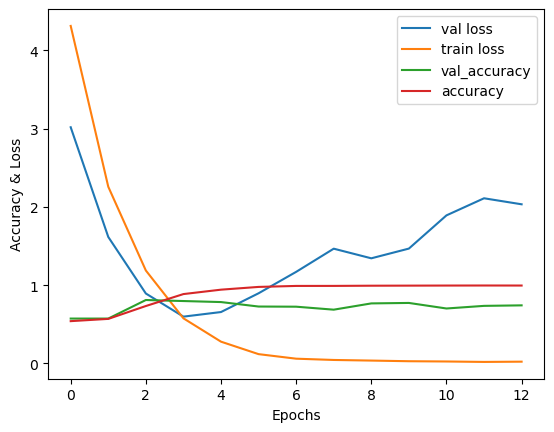

In [155]:
from matplotlib import pyplot as plt


plt.plot(history.history['val_loss'], label='val loss')
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.plot(history.history['accuracy'], label='accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy & Loss")
plt.legend()

plt.show()

In [ ]:
'''activations = ['relu']
kernel_sizes = [1, 2, 3, 4, 5, 6]

columns = ['Activation', 'Filters', 'acc1', 'acc2', 'acc3','acc4','acc5', 'AVG']
record = pd.DataFrame(columns = columns)

# prepare cross validation with 10 splits and shuffle = True
kfold = KFold(5)


exp = 0

for activation in activations:
    for kernel_size in kernel_sizes:
        # kfold.split() will return set indices for each split
        exp+=1
        print('-------------------------------------------')
        print('Training {}: {} activation, {} kernel size.'.format(exp, activation, kernel_size))
        print('-------------------------------------------')
        acc_list = []
        for train, test in kfold.split(sentences):
            
            train_x, test_x = [], []
            train_y, test_y = [], []
            
            for i in train:
                train_x.append(sentences[i])
                train_y.append(labels[i])

            for i in test:
                test_x.append(sentences[i])
                test_y.append(labels[i])

            # Turn the labels into a numpy array
            train_y = np.array(train_y)
            test_y = np.array(test_y)

          
            train_x,test_x,vocab_size ,max_len = clean (train_x = train_x,test_x = test_x)

            # Define the input shape
            model = define_model(kernel_size, activation, input_dim=vocab_size, max_length= max_len)

            # Train the model
            model.fit(train_x, train_y, batch_size=128, epochs=100, verbose=1, callbacks=[callbacks], validation_data=(test_x, test_y))

            # evaluate the model
            loss, acc = model.evaluate(test_x, test_y, verbose=1)
            print('Test Accuracy: {}'.format(acc*100))

            acc_list.append(acc*100)
            
        mean_acc = np.array(acc_list).mean()
        parameters = [activation, kernel_size]
        entries = parameters + acc_list + [mean_acc]

        temp = pd.DataFrame([entries], columns=columns)
        record = record.append(temp, ignore_index=True)
        print()
        print(record)
        print()
    '''

In [156]:
test= test_df.iloc[:,[0,3]]
sentences_test = list(test.text)
test.head()

,id,text
0,0,Just happened a terrible car crash
1,2,"Heard about #earthquake is different cities, s..."
2,3,"there is a forest fire at spot pond, geese are..."
3,9,Apocalypse lighting. #Spokane #wildfires
4,11,Typhoon Soudelor kills 28 in China and Taiwan


In [157]:
pred=[]
for itr in range(len(sentences_test)):
    pred.append(sentences_test[itr])
    
Xtest,vocab_size = clean(pred = pred)

In [158]:
Xtest[100]

array([4293,   56,   35,  108,  575,   22,    2,    3, 4294,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0],
      dtype=int32)

In [159]:
y_pred=model.predict(Xtest)
y_pred

102/102 [==============================] - 1s 5ms/step


array([[0.33043197],
       [0.35736936],
       [0.30263925],
       ...,
       [0.3926076 ],
       [0.39046726],
       [0.3254745 ]], dtype=float32)

In [160]:
y_predicted1 = np.where(y_pred > 0.5, 1, 0)

In [161]:
import csv


csv_file = '/kaggle/working/testanswer.csv'
column_name = 'target'

# open the CSV file for writing and create a csv.writer object
with open(csv_file, mode='w', newline='') as file:
    writer = csv.writer(file)

    # write the column name as the first row
    writer.writerow([column_name])

    # write the values from the list to the specified column
    for value in y_predicted1:
        writer.writerow(value)